In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
%matplotlib inline

In [2]:
def read_parameters_and_atoms(files):
    """return a list of tuples holding pairs of supercell and corresponding ase parameters"""
    parameters_and_atoms = [(read(fil, 0, 'aims-output'), 
                             eval((fil.parent / 'parameters.ase').open().read())) 
                            for fil in files]
    return parameters_and_atoms

In [3]:
def create_dataframe(scells_and_params):
    """Create pandas.Dataframe for list of tuples of supercells and parameters"""
    df = pd.DataFrame()
    for (sc, p) in scells_and_params:
        k_grid = [int(k) for k in p['k_grid'].split()]
        df = df.append({
            'n_atoms': len(sc),
            'vol': sc.get_volume(),
            'k_grid': k_grid,
            'n_k': k_grid[0]*k_grid[1]*k_grid[2],
            'e_tot': sc.get_total_energy() / len(sc),
            'f_max': np.linalg.norm(sc.get_forces(), axis=1).max()
        },
        ignore_index=True)
    return df

In [4]:
files_wo_disp = Path('disp=0.00/').glob('**/*aims.out')
supercells_wo_disp = read_parameters_and_atoms(files_wo_disp)

In [5]:
files_w_disp = Path('disp=0.08/').glob('**/*aims.out')
supercells_w_disp = read_parameters_and_atoms(files_w_disp)

In [6]:
# create datasets for supercells with and without displacement
df_w_disp = create_dataframe(supercells_w_disp)
df_wo_disp = create_dataframe(supercells_wo_disp)

In [7]:
# example
df_wo_disp.head()

,e_tot,f_max,k_grid,n_atoms,n_k,vol
0,-7886.863161,0.000068,"[4, 4, 4]",2.0,64.0,40.484577
1,-7886.960596,0.000073,"[2, 2, 2]",156.0,8.0,3157.796981
2,-7886.960596,0.000073,"[2, 2, 2]",156.0,8.0,3157.796981
3,-7886.960521,0.000246,"[2, 2, 2]",180.0,8.0,3643.611902
4,-7886.960551,0.000073,"[2, 2, 2]",216.0,8.0,4372.334282


In [8]:
# add kpoint density as a column
for df in (df_w_disp, df_wo_disp):
    df['k_density'] = df.n_k * df.vol / 100

### k point convergence

In [9]:
view = df_wo_disp.loc[df_wo_disp.n_atoms == 12].sort_values('n_k')
view.drop_duplicates(subset='n_k', inplace=True)
# energy difference in mev
view.e_tot = (view.e_tot - df_wo_disp.e_tot.min()) * 1000
view.head()

,e_tot,f_max,k_grid,n_atoms,n_k,vol,k_density
14,47.798663,0.000076,"[2, 2, 2]",12.0,8.0,242.90746,19.432597
119,0.228149,0.000158,"[5, 3, 5]",12.0,75.0,242.90746,182.180595
56,0.056470,0.000059,"[6, 4, 6]",12.0,144.0,242.90746,349.786743
98,0.012627,0.000077,"[7, 5, 7]",12.0,245.0,242.90746,595.123277
35,0.003045,0.000073,"[8, 6, 8]",12.0,384.0,242.90746,932.764647


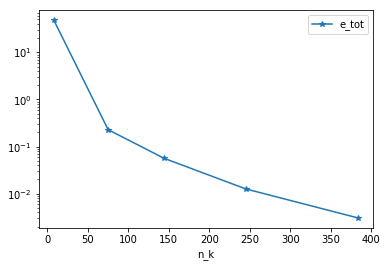

In [10]:
view.plot(x='n_k', y='e_tot', logy=True, marker='*')

# Force convergence

In [11]:
df_w_disp.head()

,e_tot,f_max,k_grid,n_atoms,n_k,vol,k_density
0,-7886.841126,1.079224,"[4, 4, 4]",2.0,64.0,40.484577,25.910129
1,-7886.960335,1.047281,"[2, 2, 2]",156.0,8.0,3157.796981,252.623759
2,-7886.960335,1.047281,"[2, 2, 2]",156.0,8.0,3157.796981,252.623759
3,-7886.960296,1.047740,"[2, 2, 2]",180.0,8.0,3643.611902,291.488952
4,-7886.960362,1.047695,"[2, 2, 2]",216.0,8.0,4372.334282,349.786743


## Force convergence with system size

In [12]:
view = df_w_disp.loc[df_w_disp.k_density > 30].sort_values(['n_atoms', 'k_density'])
view.drop_duplicates(subset='n_atoms', keep='first', inplace=True)
view.f_max = (view.f_max - view.iloc[-1].f_max) * 1000 # meV/AA
view.head()

,e_tot,f_max,k_grid,n_atoms,n_k,vol,k_density
42,-7886.939281,25.488494,"[10, 8, 10]",2.0,800.0,40.484577,323.876613
56,-7886.957214,2.677833,"[6, 4, 6]",12.0,144.0,242.907460,349.786743
20,-7886.950750,-3.524414,"[2, 2, 2]",20.0,8.0,404.845767,32.387661
8,-7886.955851,1.993534,"[2, 2, 2]",36.0,8.0,728.722380,58.297790
7,-7886.956130,3.067902,"[2, 2, 2]",48.0,8.0,971.629840,77.730387


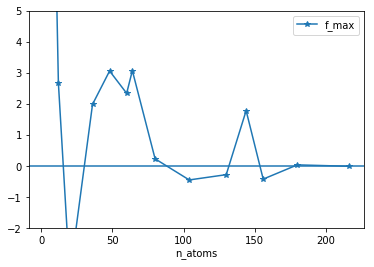

In [13]:
view.plot(x='n_atoms', y='f_max', marker='*')
plt.ylim([-2, 5])
plt.axhline(0)